<a href="https://colab.research.google.com/github/lc0/practical-ml-dahoam/blob/part-1/02_Simple_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TF2 setup

In [2]:
!pip install tf-nightly-gpu-2.0-preview

In [79]:
import tensorflow as tf

print(tf.version.VERSION)
print(tf.test.is_gpu_available())

%load_ext tensorboard

2.0.0-dev20190521
True


In [0]:
import datetime, os

import numpy as np
from matplotlib import pyplot as plt

In [0]:
TARGET_SIZE = [192, 192]
# TODO: clean-up IMAGE_SIZE
IMAGE_SIZE = TARGET_SIZE

GCS_PATTERN = 'google_dataset/*/*.jpg'
GCS_OUTPUT = './'


# steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
steps_per_epoch = 32
EPOCHS = 1

In [0]:
# TODO: clean-up this one
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels, _, _, _, _ in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels = ses.run(get_next_item)

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

### Read data

In [0]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers
        "one_hot_class": tf.io.VarLenFeature(tf.float32)        # a certain number of floats
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    return image, class_num, label, height, width, one_hot_class
    
# read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
# to read from multiple TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

dataset4 = tf.data.Dataset.list_files(GCS_OUTPUT + "*.tfrec")
dataset4 = dataset4.with_options(option_no_order)
#dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=16)
dataset4 = dataset4.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset4 = dataset4.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset4 = dataset4.shuffle(300)

display_dataset = dataset4.map(lambda image, class_num, label, height, width, one_hot_class: (image, label))

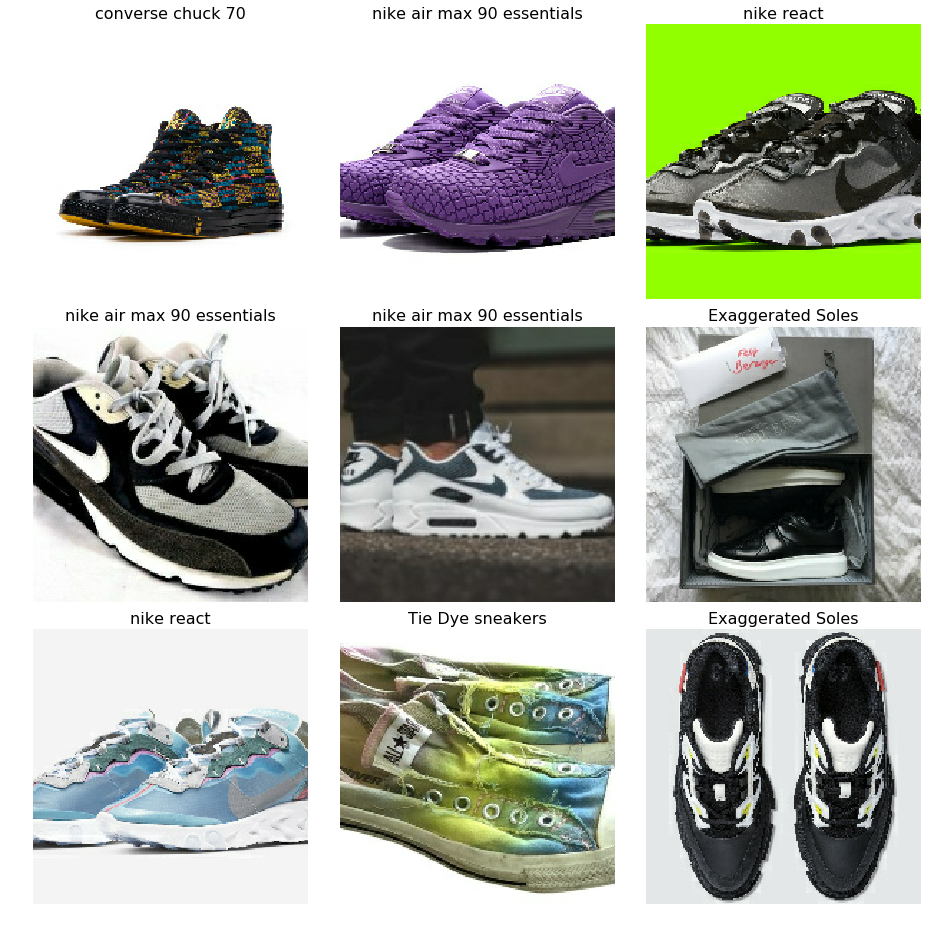

In [30]:
display_9_images_from_dataset(display_dataset)

### Model

#### training and validation datasets

In [0]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

# TODO: replace to number of classes in last layer

def create_model():
  ### QUESTION 1.
  model = tf.keras.Sequential([
      pretrained_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(5, activation='softmax')
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss = 'categorical_crossentropy',
      metrics=['accuracy']
  )

  model.summary()
  
  return model

# little wrinkle: in eager mode, only tf.train.*Optimizer optimizers will work in model.compile,
# not strings like 'adam' which map to Keras optimizers. Unfortunately the TF optimizers do not
# support Keras learning rate schedules (tf.keras.callbacks.LearningRateScheduler).
# A fix is in the works.

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000


train_dataset = dataset4.map(lambda image, class_num, label, height, width, one_hot_class: (image, one_hot_class))

train_batches = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [68]:
for image_batch, label_batch in train_batches.take(1):
  print(image_batch.shape, label_batch.shape)
  
print(label_batch[0].numpy())

(32, 192, 192, 3) (32, 5)
[0. 0. 0. 0. 1.]


In [81]:
model = create_model()

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


model.fit(train_batches, steps_per_epoch=steps_per_epoch, epochs=2,
#                     validation_data=validation_dataset, validation_steps=validation_steps)
          callbacks=[tensorboard_callback])

  

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
flatten_7 (Flatten)          (None, 46080)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 230405    
Total params: 2,488,389
Trainable params: 230,405
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/2
32/32 [==============================] - 4s 124ms/step - loss: 0.9821 - accuracy: 0.8389
Epoch 2/2
32/32 [==============================] - 2s 66ms/step - loss: 0.0071 - accuracy: 0.9980


In [0]:
%tensorboard --logdir logs

### Links


*   https://www.tensorflow.org/alpha/tutorials/images/intro_to_cnns
*   https://www.tensorflow.org/alpha/tutorials/images/hub_with_keras
*   https://www.tensorflow.org/alpha/tutorials/images/transfer_learning
*   https://www.tensorflow.org/tensorboard/r2/tensorboard_in_notebooks

